In [96]:
import pandas as pd
import numpy as np
import warnings
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind


warnings.filterwarnings("ignore")

# Show all columns in pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None) # show full content of each cell (no truncation)

DATE_STR = '2025-08-11'

In [97]:
#read processed datasets into memory if already exists
directory = os.path.join('cat', DATE_STR, 'adoptable')
adoptable_cats = pd.read_csv(directory + '/processed_adoptable_cats.csv')

directory = os.path.join('cat', DATE_STR, 'adopted')
adopted_cats = pd.read_csv(directory + '/processed_adopted_cats.csv')

In [98]:


def analyze_cat_adoption_patterns(df, target_col, training_features=None, 
                                color_col='color', test_size=0.2, 
                                random_state=42, min_color_count=30):
    """
    Comprehensive analysis of cat adoption patterns with XGBoost modeling and color spectrum analysis.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input dataframe containing cat adoption data
    target_col : str
        Name of the target column (e.g., 'days_to_adopt', 'days_in_shelter')
    training_features : list, optional
        List of column names to use as features. If None, uses all columns except target
    color_col : str, default='color'
        Name of the column containing color information
    test_size : float, default=0.2
        Proportion of data to use for testing
    random_state : int, default=42
        Random state for reproducibility
    min_color_count : int, default=30
        Minimum number of cats per color to include in detailed analysis
        
    Returns:
    --------
    dict : Dictionary containing analysis results including:
        - model: trained XGBoost model
        - feature_importance: DataFrame of feature importances
        - model_metrics: dict with RMSE and R² scores
        - color_analysis: comprehensive color statistics
        - predictions: test set predictions
    """
    
    # Input validation
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in dataframe")
    
    if color_col not in df.columns:
        raise ValueError(f"Color column '{color_col}' not found in dataframe")
    
    # Create working copy
    df_work = df.copy()
    
    print(f"Dataset Overview:")
    print(f"Shape: {df_work.shape}")
    print(f"{target_col} - Mean: {df_work[target_col].mean():.1f}, Median: {df_work[target_col].median():.1f}")
    
    # Prepare training features
    if training_features is None:
        training_features = [col for col in df_work.columns if col != target_col]
    
    # Select only available training features
    available_features = [col for col in training_features if col in df_work.columns]
    if len(available_features) != len(training_features):
        missing = set(training_features) - set(available_features)
        print(f"Warning: Missing features: {missing}")
    
    # Prepare training data
    training_data = df_work[available_features].copy()
    
    # Preprocessing
    processed_data = preprocess_training_data(training_data)
    
    print(f"\nProcessed dataset shape: {processed_data.shape}")
    
    # Prepare features and target
    X = processed_data
    y = df_work[target_col].copy()
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print(f"\nTraining set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    # Build and train XGBoost model
    print("\nTraining XGBoost model...")
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=random_state,
        n_jobs=-1
    )
    
    xgb_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = xgb_model.predict(X_test)
    
    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nModel Performance:")
    print(f"RMSE: {rmse:.2f} days")
    print(f"R²: {r2:.3f}")
    
    # Feature Importance Analysis
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))
    
    # Create visualizations
    create_comprehensive_visualizations(
        df_work, X_test, y_test, y_pred, feature_importance, 
        target_col, color_col, min_color_count
    )
    
    # Comprehensive color analysis
    color_analysis_results = perform_color_spectrum_analysis(
        df_work, target_col, color_col, min_color_count
    )
    
    # Black cat syndrome analysis
    black_cat_analysis = analyze_black_cat_syndrome(
        df_work, target_col, color_col, feature_importance
    )
    
    # Generate conclusions and recommendations
    generate_conclusions_and_recommendations(
        df_work, target_col, color_analysis_results, 
        black_cat_analysis, feature_importance, rmse, r2
    )
    
    # Prepare return dictionary
    results = {
        'model': xgb_model,
        'feature_importance': feature_importance,
        'model_metrics': {'rmse': rmse, 'r2': r2},
        'color_analysis': color_analysis_results,
        'black_cat_analysis': black_cat_analysis,
        'predictions': {'y_test': y_test, 'y_pred': y_pred},
        'processed_features': X.columns.tolist()
    }
    
    return results


def preprocess_training_data(training_data):
    """Preprocess training data for XGBoost model."""
    df_processed = training_data.copy()
    
    # Identify categorical and boolean columns
    categorical_cols = df_processed.select_dtypes(['object']).columns.to_list()
    bool_cols = df_processed.select_dtypes(['bool']).columns.to_list()
    
    # One-hot encode categorical variables
    if categorical_cols:
        df_processed = pd.get_dummies(df_processed, columns=categorical_cols, prefix=categorical_cols)
    
    # Convert boolean columns to int
    for col in bool_cols:
        df_processed[col] = df_processed[col].astype(int)
    
    return df_processed


def create_comprehensive_visualizations(df, X_test, y_test, y_pred, feature_importance, 
                                      target_col, color_col, min_color_count):
    """Create comprehensive visualizations for the analysis."""
    
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    
    # 1. Feature Importance Plot
    top_features = feature_importance.head(20)
    axes[0, 0].barh(range(len(top_features)), top_features['importance'])
    axes[0, 0].set_yticks(range(len(top_features)))
    axes[0, 0].set_yticklabels(top_features['feature'])
    axes[0, 0].set_xlabel('Feature Importance')
    axes[0, 0].set_title('Top 20 Feature Importance (XGBoost)')
    axes[0, 0].invert_yaxis()
    
    # 2. Full Color Spectrum Analysis
    color_analysis = df.groupby(color_col)[target_col].agg(['mean', 'median', 'count', 'std']).reset_index()
    color_analysis = color_analysis[color_analysis['count'] >= min_color_count]
    color_analysis = color_analysis.sort_values('mean', ascending=False)
    
    # Top colors by count for readability
    top_colors = color_analysis.nlargest(15, 'count')
    if len(top_colors) > 0:
        y_pos = range(len(top_colors))
        axes[0, 1].barh(y_pos, top_colors['mean'], xerr=top_colors['std']/np.sqrt(top_colors['count']))
        axes[0, 1].set_yticks(y_pos)
        axes[0, 1].set_yticklabels(top_colors[color_col])
        axes[0, 1].set_xlabel(f'Average {target_col}')
        axes[0, 1].set_title(f'Average {target_col} by Color (Top 15 by Count)')
        axes[0, 1].invert_yaxis()
    
    # 3. Color Category Analysis
    if 'color_category' in df.columns:
        category_analysis = df.groupby('color_category')[target_col].agg(['mean', 'median', 'count', 'std']).reset_index()
        category_analysis = category_analysis.sort_values('mean', ascending=False)
        
        axes[1, 0].bar(range(len(category_analysis)), category_analysis['mean'], 
                       yerr=category_analysis['std']/np.sqrt(category_analysis['count']))
        axes[1, 0].set_xticks(range(len(category_analysis)))
        axes[1, 0].set_xticklabels(category_analysis['color_category'], rotation=45, ha='right')
        axes[1, 0].set_ylabel(f'Average {target_col}')
        axes[1, 0].set_title(f'Average {target_col} by Color Category')
        
        # 4. Boxplot comparison
        categories_for_comparison = ['Black', 'White/Light', 'Orange/Red', 'Gray/Silver', 'Calico/Tortie']
        comparison_data = []
        comparison_labels = []
        
        for cat in categories_for_comparison:
            if cat in df['color_category'].values:
                data = df[df['color_category'] == cat][target_col]
                if len(data) >= 20:
                    comparison_data.append(data)
                    comparison_labels.append(f"{cat}\n(n={len(data)})")
        
        if comparison_data:
            axes[1, 1].boxplot(comparison_data, labels=comparison_labels)
            axes[1, 1].set_ylabel(target_col)
            axes[1, 1].set_title(f'{target_col} Distribution by Major Color Categories')
            axes[1, 1].tick_params(axis='x', rotation=45)
    
    # 5. Heatmap of Color vs Age (if age column exists)
    if 'color_category' in df.columns and 'age' in df.columns:
        color_feature_analysis = df.groupby(['color_category', 'age'])[target_col].mean().unstack(fill_value=0)
        if not color_feature_analysis.empty:
            im = axes[2, 0].imshow(color_feature_analysis.values, cmap='viridis', aspect='auto')
            axes[2, 0].set_xticks(range(len(color_feature_analysis.columns)))
            axes[2, 0].set_xticklabels(color_feature_analysis.columns)
            axes[2, 0].set_yticks(range(len(color_feature_analysis.index)))
            axes[2, 0].set_yticklabels(color_feature_analysis.index)
            axes[2, 0].set_title(f'Average {target_col}: Color Category vs Age')
            plt.colorbar(im, ax=axes[2, 0])
    
    # 6. Model predictions vs actual
    axes[2, 1].scatter(y_test, y_pred, alpha=0.5)
    axes[2, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[2, 1].set_xlabel(f'Actual {target_col}')
    axes[2, 1].set_ylabel(f'Predicted {target_col}')
    axes[2, 1].set_title('Model Predictions vs Actual Values')
    
    plt.tight_layout()
    plt.show()


def perform_color_spectrum_analysis(df, target_col, color_col, min_color_count):
    """Perform comprehensive color spectrum analysis."""
    
    print(f"\n{'='*80}")
    print("COMPREHENSIVE COLOR SPECTRUM ANALYSIS")
    print(f"{'='*80}")
    
    # Full color analysis
    print("\n1. DETAILED COLOR BREAKDOWN:")
    print("-" * 50)
    full_color_stats = df.groupby(color_col)[target_col].agg(['count', 'mean', 'median', 'std']).round(1)
    full_color_stats = full_color_stats.sort_values('mean', ascending=False)
    full_color_stats.columns = ['Count', 'Mean_Days', 'Median_Days', 'Std_Days']
    
    # Only show colors with reasonable sample sizes
    significant_colors = full_color_stats[full_color_stats['Count'] >= min_color_count]
    print(significant_colors.to_string())
    
    results = {'significant_colors': significant_colors}
    
    # Color category analysis
    if 'color_category' in df.columns:
        print(f"\n2. COLOR CATEGORY ANALYSIS:")
        print("-" * 50)
        category_stats = df.groupby('color_category')[target_col].agg(['count', 'mean', 'median', 'std']).round(1)
        category_stats = category_stats.sort_values('mean', ascending=False)
        category_stats.columns = ['Count', 'Mean_Days', 'Median_Days', 'Std_Days']
        print(category_stats.to_string())
        results['category_stats'] = category_stats
        
        # Statistical comparisons
        comparison_results = perform_category_comparisons(df, target_col, category_stats)
        results['comparisons'] = comparison_results
    
    # Individual color performance ranking
    print(f"\n4. INDIVIDUAL COLOR PERFORMANCE RANKING:")
    print("-" * 50)
    print(f"(Colors with at least {min_color_count} cats in dataset)")
    
    if 'color_category' in df.columns:
        color_ranking = rank_individual_colors(df, target_col, color_col, min_color_count)
        results['color_ranking'] = color_ranking
    
    # Pattern analysis
    pattern_results = analyze_color_patterns(df, target_col, color_col)
    results['pattern_analysis'] = pattern_results
    
    # Performance insights
    performance_insights = analyze_color_performance(df, target_col, significant_colors)
    results['performance_insights'] = performance_insights
    
    return results


def perform_category_comparisons(df, target_col, category_stats):
    """Perform statistical comparisons between color categories."""
    
    print(f"\n3. STATISTICAL COMPARISONS BETWEEN COLOR CATEGORIES:")
    print("-" * 50)
    
    categories = category_stats.index.tolist()
    comparison_results = []
    
    for i, cat1 in enumerate(categories):
        for cat2 in categories[i+1:]:
            data1 = df[df['color_category'] == cat1][target_col]
            data2 = df[df['color_category'] == cat2][target_col]
            
            if len(data1) >= 20 and len(data2) >= 20:
                t_stat, p_val = stats.ttest_ind(data1, data2)
                mean_diff = data1.mean() - data2.mean()
                
                # Calculate effect size
                pooled_std = np.sqrt(((len(data1) - 1) * data1.var() + 
                                     (len(data2) - 1) * data2.var()) / 
                                    (len(data1) + len(data2) - 2))
                cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
                
                significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                
                comparison_results.append({
                    'Comparison': f"{cat1} vs {cat2}",
                    'Mean_Diff': round(mean_diff, 1),
                    'p_value': f"{p_val:.4f}",
                    'Effect_Size': round(cohens_d, 3),
                    'Significance': significance
                })
    
    # Sort by absolute effect size
    comparison_df = pd.DataFrame(comparison_results)
    if not comparison_df.empty:
        comparison_df['Abs_Effect'] = abs(comparison_df['Effect_Size'])
        comparison_df = comparison_df.sort_values('Abs_Effect', ascending=False)
        comparison_df = comparison_df.drop('Abs_Effect', axis=1)
        
        print(comparison_df.to_string(index=False))
        print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
    
    return comparison_results


def rank_individual_colors(df, target_col, color_col, min_color_count):
    """Rank individual colors by performance."""
    
    print(f"{'Rank':<4} {'Color':<35} {'Count':<6} {'Avg Days':<10} {'Category'}")
    print("-" * 75)
    
    color_with_category = df.groupby([color_col, 'color_category'])[target_col].agg(['count', 'mean']).reset_index()
    color_with_category = color_with_category[color_with_category['count'] >= min_color_count]
    color_with_category = color_with_category.sort_values('mean', ascending=True)
    
    for idx, (_, row) in enumerate(color_with_category.iterrows()):
        rank = idx + 1
        print(f"{rank:<4} {row[color_col]:<35} {int(row['count']):<6} {row['mean']:.1f}{'d':<9} {row['color_category']}")
    
    return color_with_category


def analyze_color_patterns(df, target_col, color_col):
    """Analyze color family patterns (tabby, point, etc.)."""
    
    print(f"\n5. COLOR FAMILY PATTERNS:")
    print("-" * 50)
    
    results = {}
    
    # Tabby analysis
    tabby_colors = df[df[color_col].str.contains('Tabby', na=False)][target_col]
    non_tabby_colors = df[~df[color_col].str.contains('Tabby', na=False)][target_col]
    
    if len(tabby_colors) > 0 and len(non_tabby_colors) > 0:
        t_stat, p_val = stats.ttest_ind(tabby_colors, non_tabby_colors)
        print(f"TABBY PATTERN ANALYSIS:")
        print(f"  Tabby cats (n={len(tabby_colors)}): {tabby_colors.mean():.1f} days average")
        print(f"  Non-tabby cats (n={len(non_tabby_colors)}): {non_tabby_colors.mean():.1f} days average")
        print(f"  Difference: {tabby_colors.mean() - non_tabby_colors.mean():.1f} days")
        print(f"  Statistical significance: p={p_val:.4f}")
        
        results['tabby_analysis'] = {
            'tabby_mean': tabby_colors.mean(),
            'non_tabby_mean': non_tabby_colors.mean(),
            'p_value': p_val
        }
    
    # Point color analysis
    point_colors_data = df[df[color_col].str.contains('Point', na=False)][target_col]
    non_point_colors_data = df[~df[color_col].str.contains('Point', na=False)][target_col]
    
    if len(point_colors_data) > 0 and len(non_point_colors_data) > 0:
        t_stat, p_val = stats.ttest_ind(point_colors_data, non_point_colors_data)
        print(f"\nPOINT COLOR PATTERN ANALYSIS:")
        print(f"  Point colors (n={len(point_colors_data)}): {point_colors_data.mean():.1f} days average")
        print(f"  Non-point colors (n={len(non_point_colors_data)}): {non_point_colors_data.mean():.1f} days average")
        print(f"  Difference: {point_colors_data.mean() - non_point_colors_data.mean():.1f} days")
        print(f"  Statistical significance: p={p_val:.4f}")
        
        results['point_analysis'] = {
            'point_mean': point_colors_data.mean(),
            'non_point_mean': non_point_colors_data.mean(),
            'p_value': p_val
        }
    
    return results


def analyze_color_performance(df, target_col, significant_colors):
    """Analyze best and worst performing colors."""
    
    # Best and worst performing colors
    best_colors = significant_colors.tail(3)  # Lowest mean days (fastest adoption)
    worst_colors = significant_colors.head(3)  # Highest mean days (slowest adoption)
    
    print(f"\n6. BEST vs WORST PERFORMING COLORS:")
    print("-" * 50)
    print("FASTEST TO ADOPT (Top 3):")
    for color, stats in best_colors.iterrows():
        print(f"  {color}: {stats['Mean_Days']:.1f} days (n={int(stats['Count'])})")
    
    print("\nSLOWEST TO ADOPT (Bottom 3):")
    for color, stats in worst_colors.iterrows():
        print(f"  {color}: {stats['Mean_Days']:.1f} days (n={int(stats['Count'])})")
    
    print(f"\n7. COLOR-SPECIFIC INSIGHTS:")
    print("-" * 50)
    
    # Find colors that significantly outperform or underperform the overall average
    overall_mean = df[target_col].mean()
    print(f"Overall average adoption time: {overall_mean:.1f} days")
    
    fast_colors = significant_colors[significant_colors['Mean_Days'] < overall_mean - 5]
    slow_colors = significant_colors[significant_colors['Mean_Days'] > overall_mean + 5]
    
    performance_results = {
        'overall_mean': overall_mean,
        'best_colors': best_colors,
        'worst_colors': worst_colors,
        'fast_colors': fast_colors,
        'slow_colors': slow_colors
    }
    
    if len(fast_colors) > 0:
        print(f"\nColors that adopt significantly FASTER than average (>5 days faster):")
        for color, stats in fast_colors.iterrows():
            improvement = overall_mean - stats['Mean_Days']
            print(f"  {color}: {improvement:.1f} days faster than average")
    
    if len(slow_colors) > 0:
        print(f"\nColors that adopt significantly SLOWER than average (>5 days slower):")
        for color, stats in slow_colors.iterrows():
            delay = stats['Mean_Days'] - overall_mean
            print(f"  {color}: {delay:.1f} days slower than average")
    
    return performance_results


def analyze_black_cat_syndrome(df, target_col, color_col, feature_importance):
    """Analyze black cat syndrome specifically."""
    
    print(f"\n{'='*80}")
    print("BLACK CAT SYNDROME ANALYSIS")
    print(f"{'='*80}")
    
    # Get data for black cat analysis
    black_cats = df[df[color_col] == 'Black'][target_col]
    non_black_cats = df[df[color_col] != 'Black'][target_col]
    
    if len(black_cats) == 0:
        print("No black cats found in dataset")
        return {'black_cats_found': False}
    
    # Basic statistics
    black_stats = black_cats.describe()
    non_black_stats = non_black_cats.describe()
    
    print(f"\nBLACK CATS STATISTICS:")
    print(f"Count: {int(black_stats['count'])}")
    print(f"Mean: {black_stats['mean']:.1f} days")
    print(f"Median: {black_stats['50%']:.1f} days")
    print(f"Std: {black_stats['std']:.1f} days")
    
    print(f"\nNON-BLACK CATS STATISTICS:")
    print(f"Count: {int(non_black_stats['count'])}")
    print(f"Mean: {non_black_stats['mean']:.1f} days")
    print(f"Median: {non_black_stats['50%']:.1f} days")
    print(f"Std: {non_black_stats['std']:.1f} days")
    
    # Statistical significance test
    t_stat, p_value = ttest_ind(black_cats.values, non_black_cats.values, nan_policy='omit')
    print(f"\nSTATISTICAL TEST (t-test):")
    print(f"t-statistic: {t_stat:.3f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(black_cats) - 1) * black_cats.var() + 
                         (len(non_black_cats) - 1) * non_black_cats.var()) / 
                        (len(black_cats) + len(non_black_cats) - 2))
    cohens_d = (black_cats.mean() - non_black_cats.mean()) / pooled_std
    print(f"Cohen's d (effect size): {cohens_d:.3f}")
    
    # # Compare with light-colored cats if available
    # if 'is_light_colored' in df.columns:
    #     light_colored_cats = df[df['is_light_colored'] == 1][target_col]
    #     if len(light_colored_cats) > 0:
    #         t_stat_light, p_value_light = ttest_ind(black_cats.values, light_colored_cats.values)
    #         print(f"\nBLACK vs LIGHT-COLORED CATS:")
    #         print(f"Black cats mean: {black_cats.mean():.1f} days")
    #         print(f"Light-colored cats mean: {light_colored_cats.mean():.1f} days")
    #         print(f"Difference: {black_cats.mean() - light_colored_cats.mean():.1f} days")
    #         print(f"t-statistic: {t_stat_light:.3f}")
    #         print(f"p-value: {p_value_light:.6f}")
    
    # Feature importance related to color
    color_features = [col for col in feature_importance['feature'] if 'color_' in col or 'is_black' in col]
    print(f"\nCOLOR-RELATED FEATURE IMPORTANCE:")
    for feature in color_features:
        importance_val = feature_importance[feature_importance['feature'] == feature]['importance'].values
        if len(importance_val) > 0:
            print(f"{feature}: {importance_val[0]:.4f}")
    
    results = {
        'black_cats_found': True,
        'black_stats': black_stats,
        'non_black_stats': non_black_stats,
        't_statistic': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'syndrome_exists': p_value < 0.05 and cohens_d > 0.2,
        'color_feature_importance': color_features
    }
    
    return results


def generate_conclusions_and_recommendations(df, target_col, color_analysis, 
                                           black_cat_analysis, feature_importance, rmse, r2):
    """Generate comprehensive conclusions and recommendations."""
    
    print(f"\n{'='*80}")
    print("COMPREHENSIVE CONCLUSIONS AND RECOMMENDATIONS")
    print(f"{'='*80}")
    
    print(f"\n🎯 KEY FINDINGS:")
    print("-" * 40)
    print(f"1. Overall average adoption time: {df[target_col].mean():.1f} days")
    
    if black_cat_analysis.get('black_cats_found', False):
        black_cats = df[df['color'] == 'Black'][target_col]
        print(f"2. Black cats average: {black_cats.mean():.1f} days")
    
    if 'significant_colors' in color_analysis:
        significant_colors = color_analysis['significant_colors']
        print(f"3. Range across colors: {significant_colors['Mean_Days'].min():.1f} - {significant_colors['Mean_Days'].max():.1f} days")
    
    if 'category_stats' in color_analysis:
        category_stats = color_analysis['category_stats']
        print(f"4. Biggest color category difference: {category_stats['Mean_Days'].max() - category_stats['Mean_Days'].min():.1f} days")
    
    # Black cat syndrome status
    print(f"\n🐱 BLACK CAT SYNDROME STATUS:")
    print("-" * 40)
    
    if black_cat_analysis.get('syndrome_exists', False):
        black_cats = df[df['color'] == 'Black'][target_col]
        non_black_cats = df[df['color'] != 'Black'][target_col]
        p_value = black_cat_analysis['p_value']
        cohens_d = black_cat_analysis['cohens_d']
        
        print("✅ BLACK CAT SYNDROME CONFIRMED!")
        print(f"   - Black cats wait {black_cats.mean() - non_black_cats.mean():.1f} days longer on average")
        print(f"   - This difference is statistically significant (p={p_value:.4f})")
        effect_size_label = 'small' if abs(cohens_d) < 0.5 else 'medium' if abs(cohens_d) < 0.8 else 'large'
        print(f"   - Effect size is {abs(cohens_d):.3f} ({effect_size_label} effect)")
    else:
        print("❌ NO STRONG EVIDENCE OF BLACK CAT SYNDROME")
        print("   - Difference is not statistically significant or meaningful")
    
    print(f"\n📊 ACTIONABLE INSIGHTS:")
    print("-" * 40)
    
    # Color impact on model
    color_importance = feature_importance[feature_importance['feature'].str.contains('color', case=False)]
    if len(color_importance) > 0:
        print(f"1. COLOR IMPACT ON MODEL: Color features rank among top predictors")
        print(f"   - Highest color importance: {color_importance.iloc[0]['importance']:.4f}")
    
    # Marketing focus areas
    if 'category_stats' in color_analysis:
        category_stats = color_analysis['category_stats']
        slowest_category = category_stats.index[0]  # First in descending order
        fastest_category = category_stats.index[-1]  # Last in descending order
        
        print(f"2. FOCUS AREAS FOR MARKETING:")
        print(f"   - Prioritize marketing for {slowest_category} cats ({category_stats.loc[slowest_category, 'Mean_Days']:.1f} days avg)")
        print(f"   - Learn from success of {fastest_category} cats ({category_stats.loc[fastest_category, 'Mean_Days']:.1f} days avg)")
    
    # Other key factors
    top_non_color_features = feature_importance[~feature_importance['feature'].str.contains('color', case=False)].head(3)
    print(f"3. OTHER KEY FACTORS TO ADDRESS:")
    for _, feature in top_non_color_features.iterrows():
        print(f"   - {feature['feature']}: {feature['importance']:.4f} importance")
    
    print(f"\n💡 RECOMMENDATIONS:")
    print("-" * 40)
    
    if black_cat_analysis.get('syndrome_exists', False):
        print("• Develop specific marketing campaigns for black cats")
        print("• Consider adoption fee incentives for black cats")
        print("• Highlight unique personalities and characteristics")
    
    print("• Focus resources on the slowest-adopting color categories")
    print("• Investigate what makes fastest-adopting colors successful")
    print("• Consider color-specific photography and presentation strategies")
    print("• Monitor adoption patterns regularly to track improvements")
    
    print(f"\n📈 STATISTICAL SUMMARY:")
    print("-" * 40)
    print(f"• Sample size: {len(df):,} cats")
    
    if 'significant_colors' in color_analysis:
        print(f"• Colors analyzed: {len(color_analysis['significant_colors'])} (with adequate sample sizes)")
    
    print(f"• Model performance: R² = {r2:.3f}, RMSE = {rmse:.1f} days")
    print(f"• Most important features successfully capture adoption patterns")

## Adoptable Cats

Dataset Overview:
Shape: (78427, 51)
days_in_shelter - Mean: 181.8, Median: 40.0

Processed dataset shape: (78427, 41)

Training set shape: (62741, 41)
Test set shape: (15686, 41)

Training XGBoost model...

Model Performance:
RMSE: 397.83 days
R²: 0.132

Top 15 Most Important Features:
                        feature  importance
                       age_Baby    0.265274
                      age_Young    0.086996
                  house_trained    0.052460
             env_children_False    0.039541
               env_cats_Unknown    0.039193
color_category_Special Patterns    0.037276
                 gender_Unknown    0.037000
              env_children_True    0.033730
                   coat_Unknown    0.030882
          is_character_provided    0.024330
                     size_Small    0.022067
         color_category_Unknown    0.021893
                  env_cats_True    0.019320
                      age_Adult    0.018764
                    photo_count    0.017259


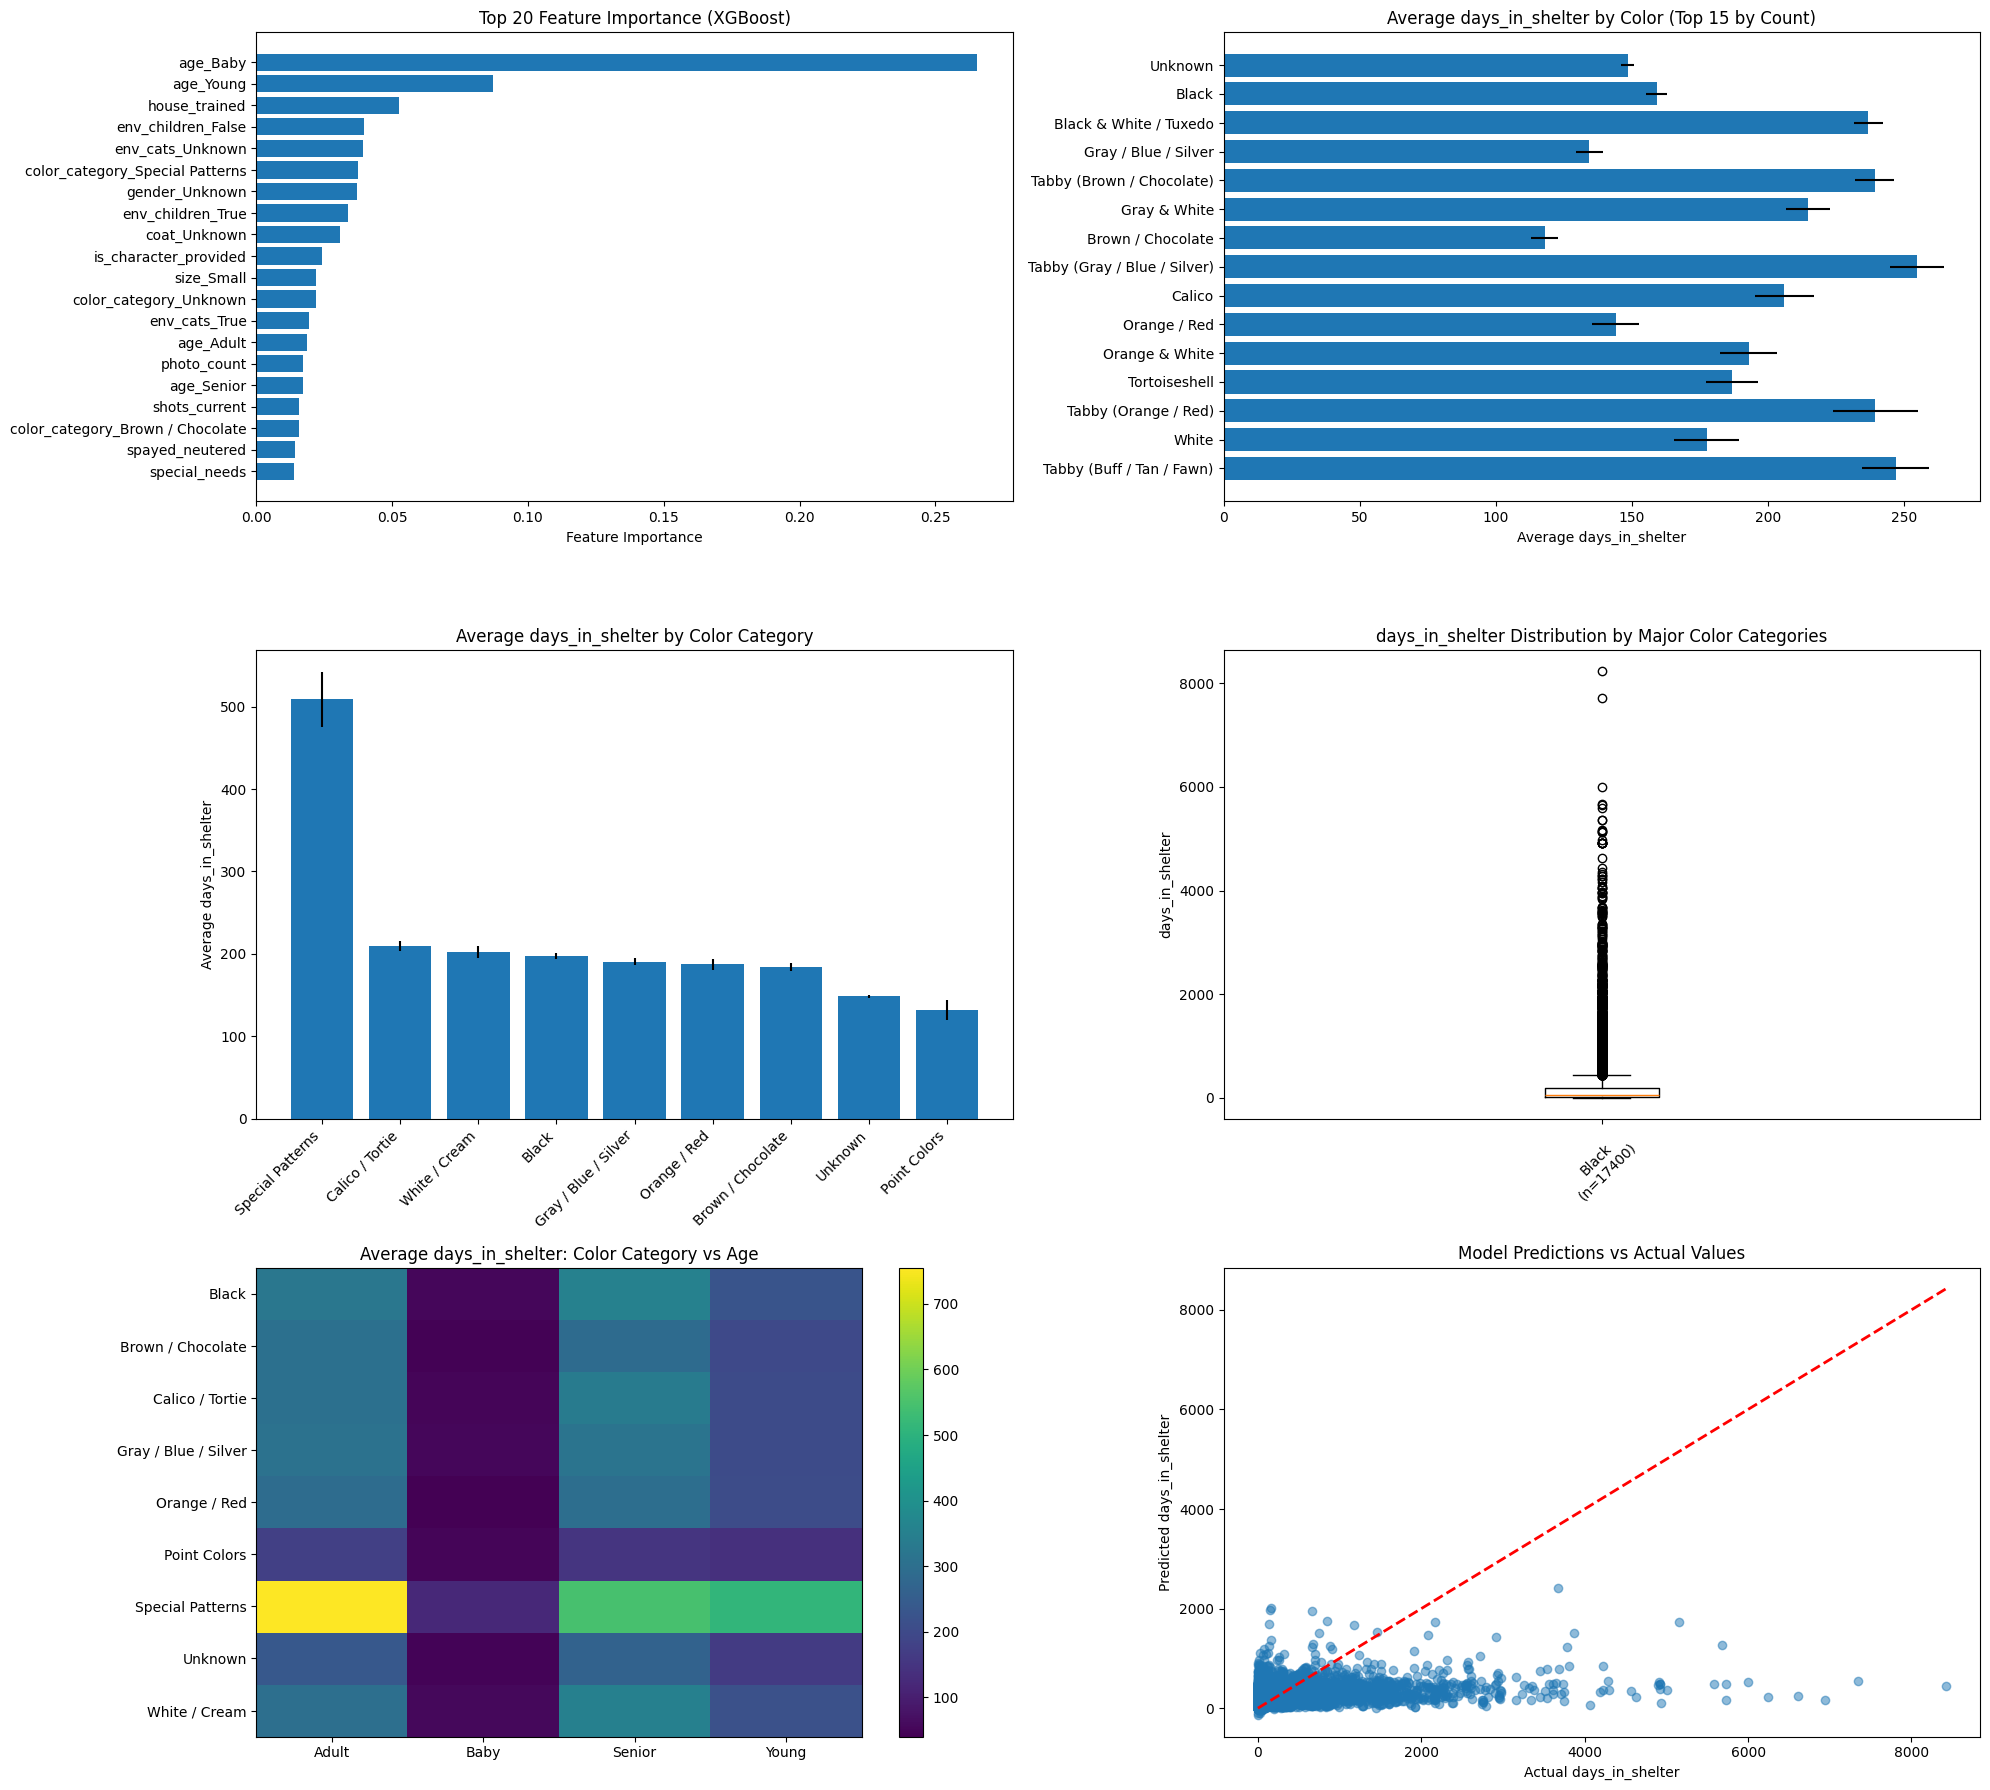


COMPREHENSIVE COLOR SPECTRUM ANALYSIS

1. DETAILED COLOR BREAKDOWN:
--------------------------------------------------
                              Count  Mean_Days  Median_Days  Std_Days
color                                                                
Tabby (Tiger Striped)           613      533.1        110.0     893.3
Tabby (Leopard / Spotted)        90      342.0         52.0     677.5
Dilute Calico                   397      276.4         73.0     482.8
Smoke                            92      271.4         28.5     660.4
Tabby (Gray / Blue / Silver)   2694      254.9         58.0     513.0
Dilute Tortoiseshell            336      249.8         72.0     410.1
Tabby (Buff / Tan / Fawn)      1029      247.1         70.0     392.2
Tabby (Orange / Red)           1548      239.5         43.0     614.7
Tabby (Brown / Chocolate)      4530      239.3         59.0     491.6
Black & White / Tuxedo         8614      236.9         54.0     493.4
Torbie                          629     

In [99]:
training_features = [
    'age', 'gender', 'size', 'coat', 'color_category', 'spayed_neutered',
    'house_trained', 'declawed', 'special_needs', 'shots_current',
    'env_children', 'env_dogs', 'env_cats', 'is_character_provided',
    'photo_count'
]

# Run the analysis
adoptable_results = analyze_cat_adoption_patterns(
    df=adoptable_cats,
    target_col='days_in_shelter',
    training_features=training_features,
    color_col='color',
    test_size=0.2,
    random_state=42,
    min_color_count=30
)

# # Access results
# model = adoptable_results['model']
# feature_importance = adoptable_results['feature_importance']
# model_metrics = adoptable_results['model_metrics']
# color_analysis = adoptable_results['color_analysis']
# black_cat_analysis = adoptable_results['black_cat_analysis']

## Adopted Cats

Dataset Overview:
Shape: (841776, 49)
days_to_adopt - Mean: 45.0, Median: 16.0

Processed dataset shape: (841776, 40)

Training set shape: (673420, 40)
Test set shape: (168356, 40)

Training XGBoost model...

Model Performance:
RMSE: 92.42 days
R²: 0.083

Top 15 Most Important Features:
                    feature  importance
                   age_Baby    0.220127
              shots_current    0.079258
                photo_count    0.064547
           env_cats_Unknown    0.060141
      is_character_provided    0.051807
         env_children_False    0.043657
                  coat_Long    0.038156
              special_needs    0.037223
color_category_Point Colors    0.030903
          env_children_True    0.026245
                  age_Young    0.024854
       color_category_Black    0.021635
                  age_Adult    0.021261
             env_dogs_False    0.020383
                   declawed    0.020123


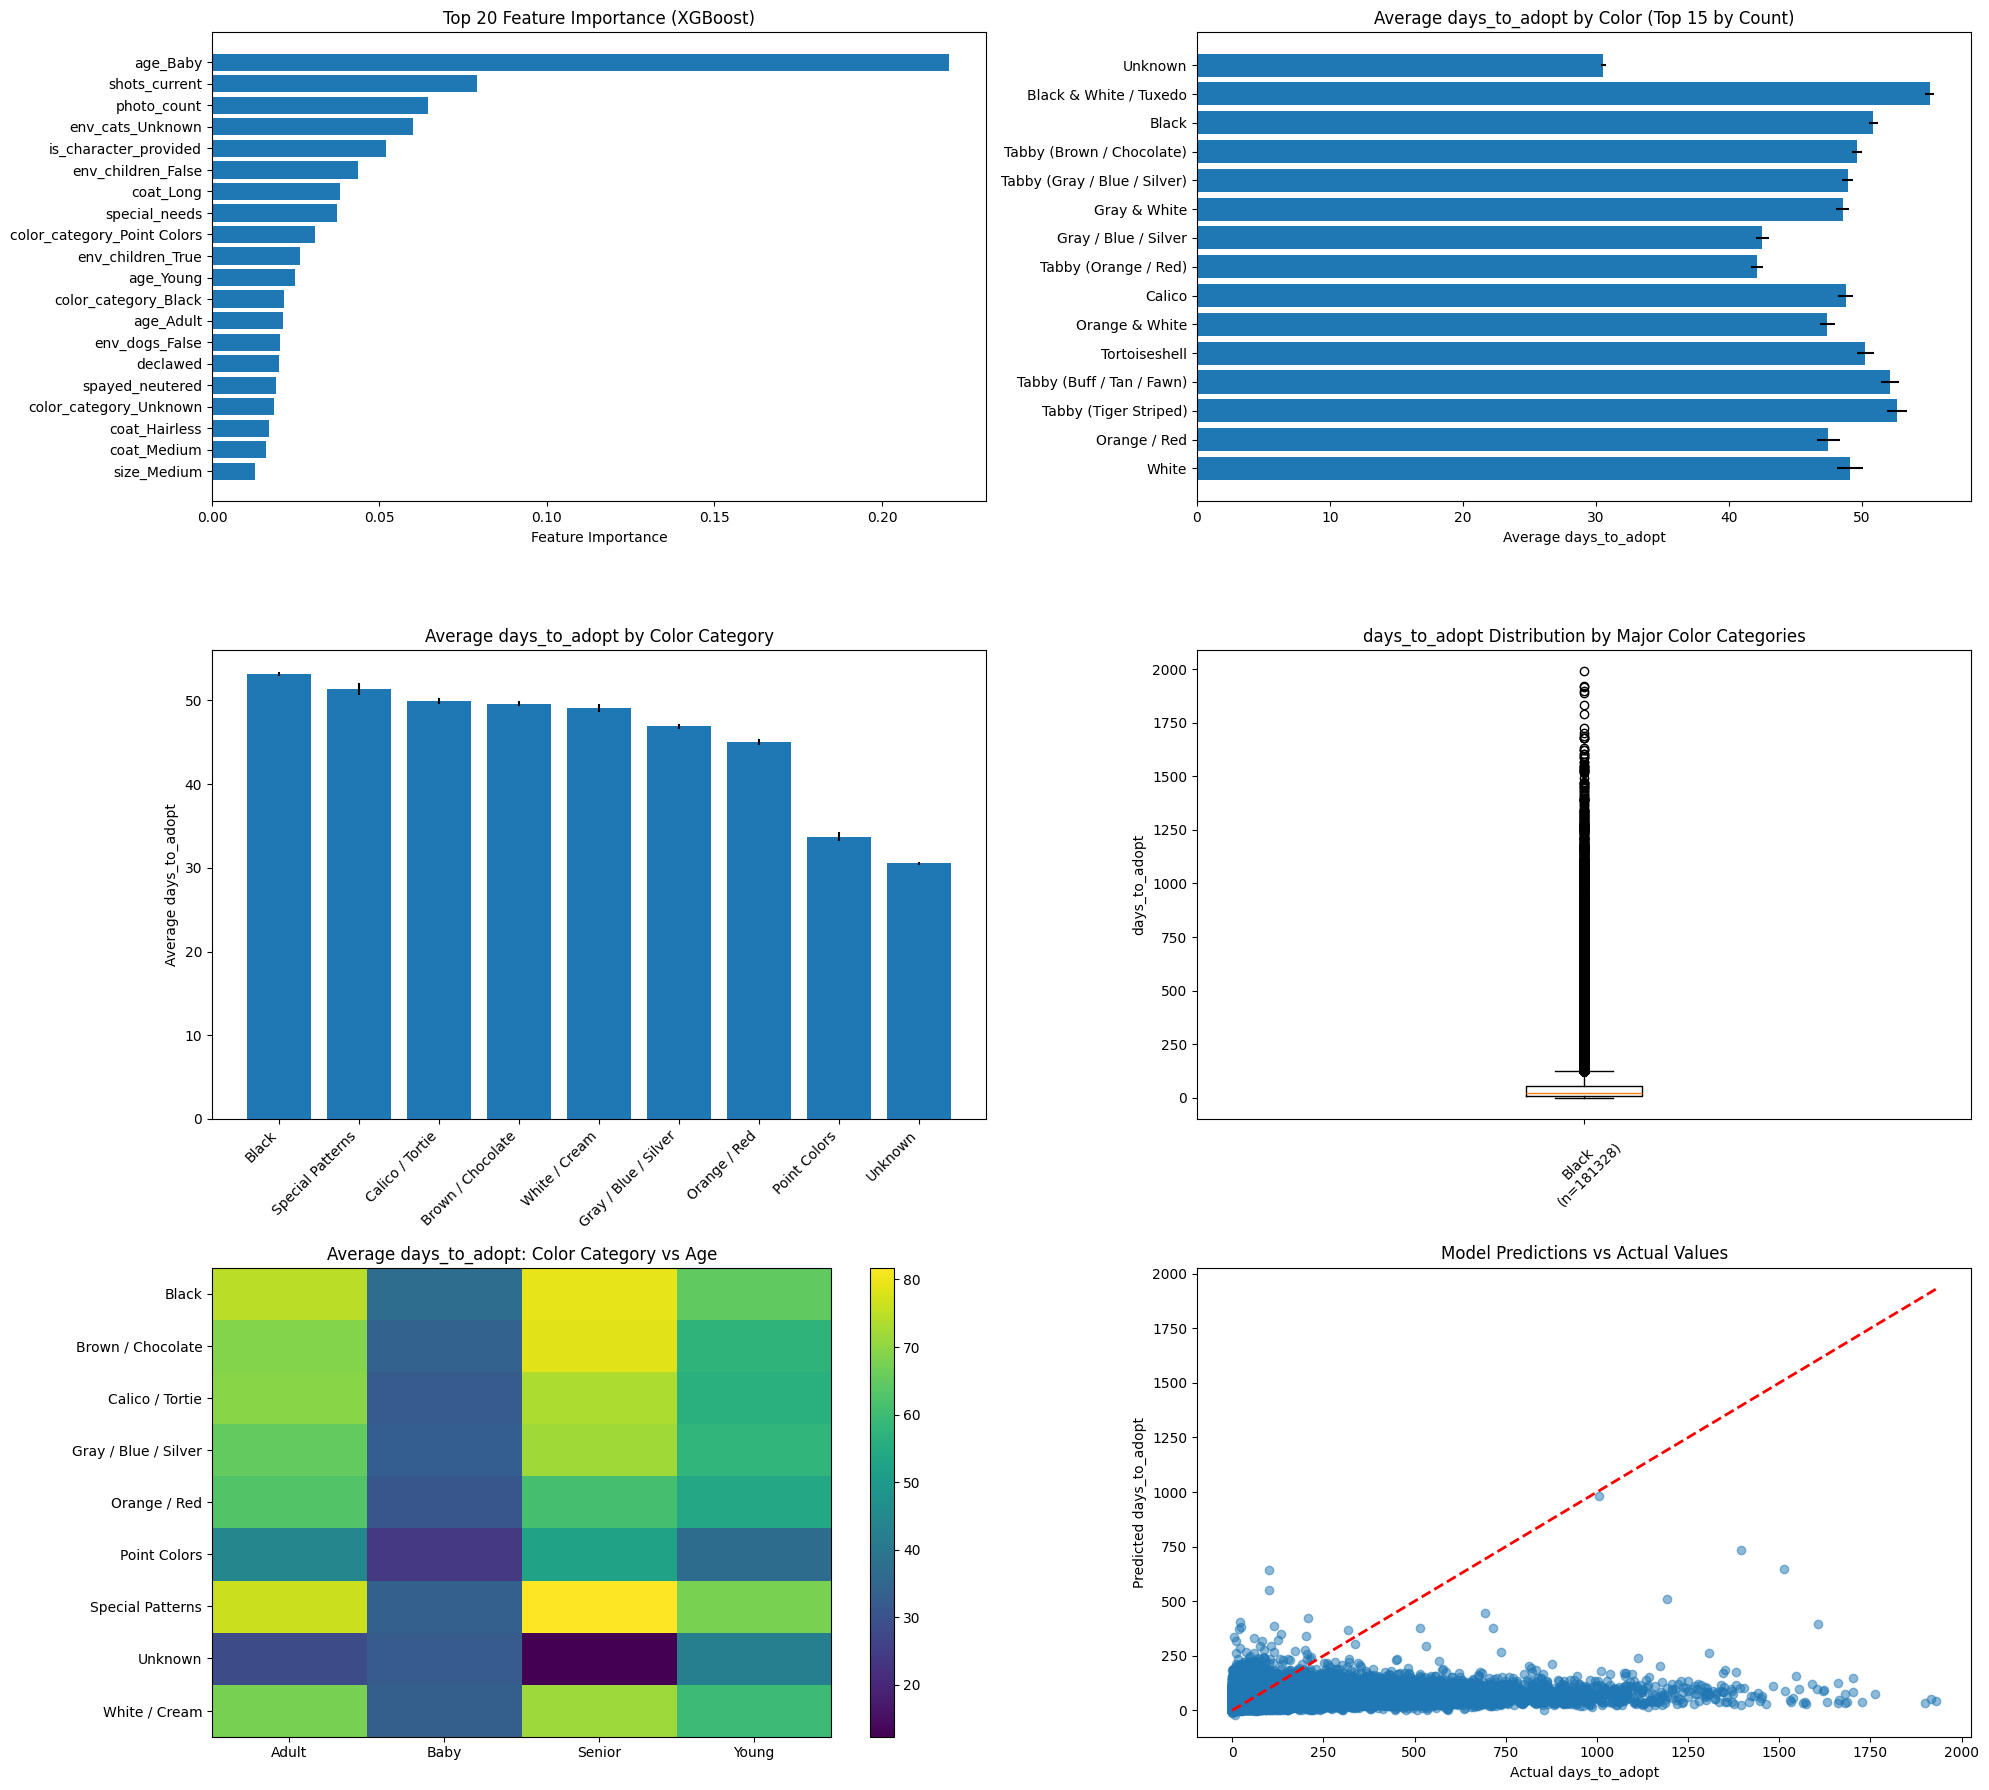


COMPREHENSIVE COLOR SPECTRUM ANALYSIS

1. DETAILED COLOR BREAKDOWN:
--------------------------------------------------
                               Count  Mean_Days  Median_Days  Std_Days
color                                                                 
Black & White / Tuxedo         96924       55.1         22.0     106.8
Tabby (Tiger Striped)          19609       52.6         20.0     103.5
Tabby (Buff / Tan / Fawn)      22614       52.1         21.0      99.6
Torbie                          9625       51.5         19.0     106.3
Dilute Tortoiseshell            7638       51.3         21.0      97.1
Brown / Chocolate               7272       51.1         17.0     108.8
Black                          84404       50.9         20.0      98.5
Tortoiseshell                  24647       50.2         20.0     100.9
Dilute Calico                  10328       50.0         19.0     101.2
Tabby (Brown / Chocolate)      77811       49.6         19.0      97.8
White                       

In [100]:
training_features = [
    'age', 'gender', 'size', 'coat', 'color_category', 'spayed_neutered',
    'house_trained', 'declawed', 'special_needs', 'shots_current',
    'env_children', 'env_dogs', 'env_cats', 'is_character_provided',
    'photo_count'
]

# Run the analysis
adopted_results = analyze_cat_adoption_patterns(
    df=adopted_cats,
    target_col='days_to_adopt',
    training_features=training_features,
    color_col='color',
    test_size=0.2,
    random_state=42,
    min_color_count=30
)

# # Access results
# model = adopted_results['model']
# feature_importance = adopted_results['feature_importance']
# model_metrics = adopted_results['model_metrics']
# color_analysis = adopted_results['color_analysis']
# black_cat_analysis = adopted_results['black_cat_analysis']


## Adopted Baby

Dataset Overview:
Shape: (378021, 49)
days_to_adopt - Mean: 33.7, Median: 15.0

Processed dataset shape: (378021, 36)

Training set shape: (302416, 36)
Test set shape: (75605, 36)

Training XGBoost model...

Model Performance:
RMSE: 64.67 days
R²: 0.023

Top 15 Most Important Features:
                    feature  importance
                  coat_Long    0.074031
                photo_count    0.069419
                size_Medium    0.056683
      is_character_provided    0.055644
           env_cats_Unknown    0.049317
          env_children_True    0.044261
color_category_Point Colors    0.040321
color_category_Orange / Red    0.039851
              special_needs    0.038405
       color_category_Black    0.037134
              env_dogs_True    0.029290
             env_dogs_False    0.028821
            spayed_neutered    0.027944
                 coat_Short    0.027897
                 size_Small    0.026405


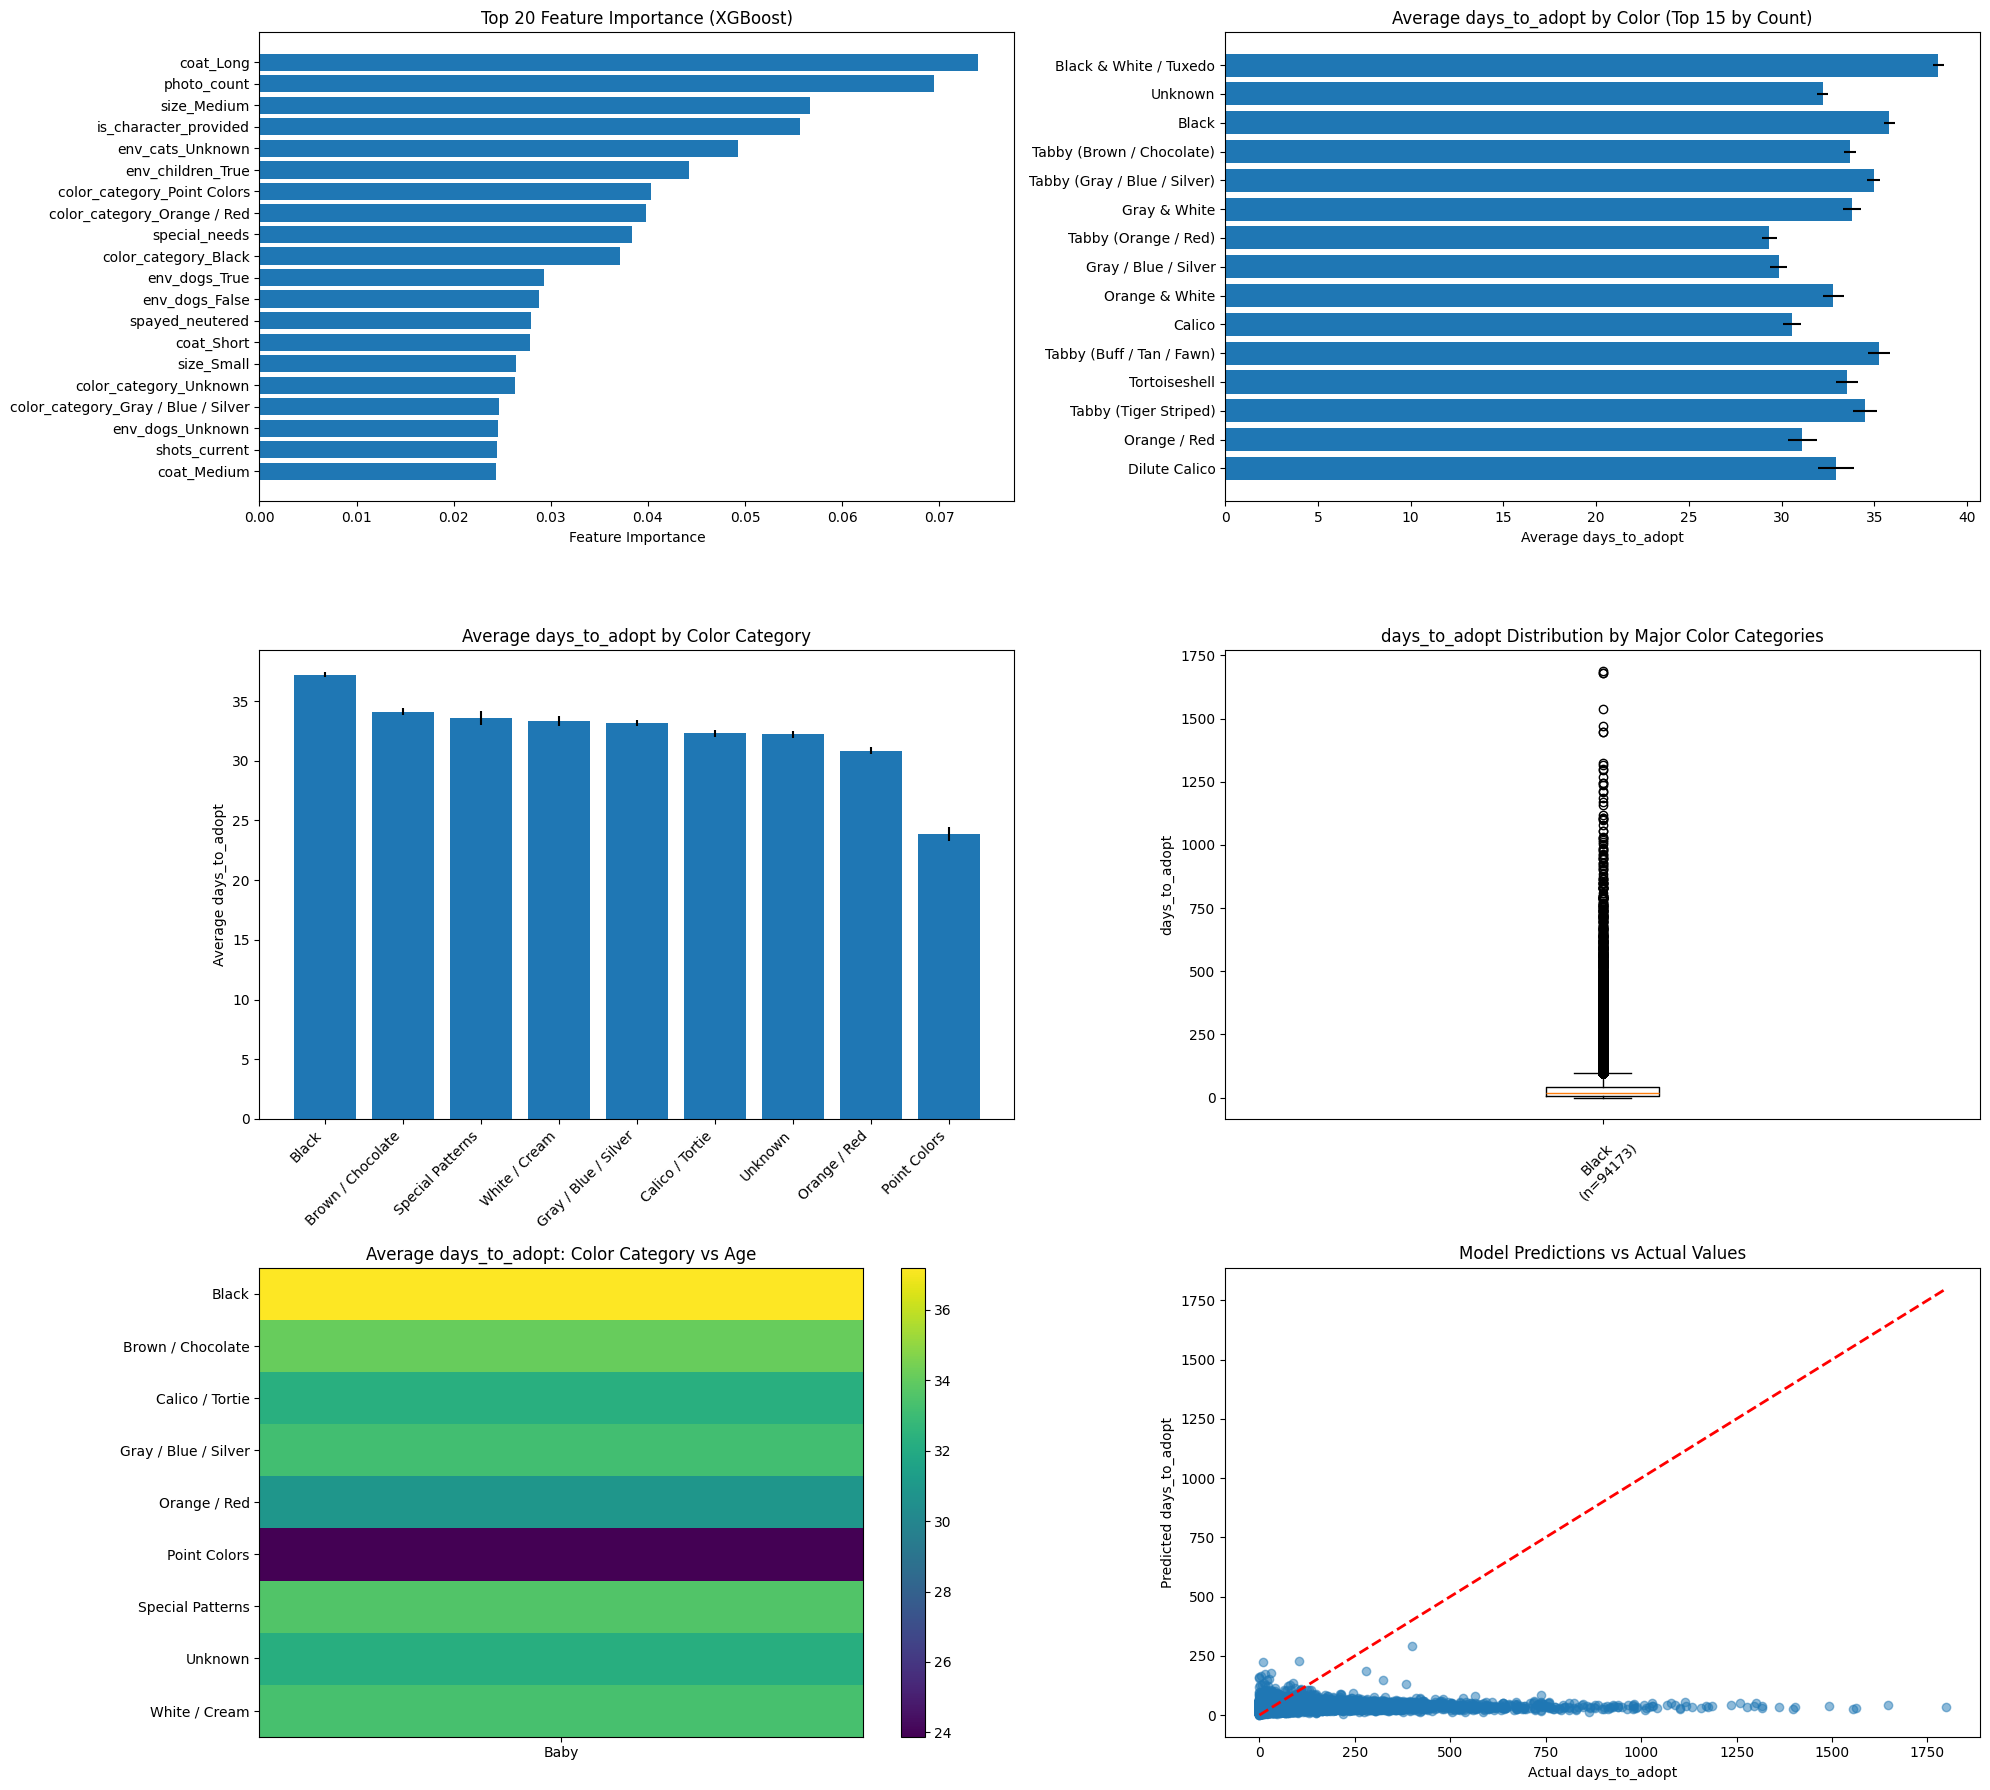


COMPREHENSIVE COLOR SPECTRUM ANALYSIS

1. DETAILED COLOR BREAKDOWN:
--------------------------------------------------
                              Count  Mean_Days  Median_Days  Std_Days
color                                                                
Brown / Chocolate              3138       38.6         14.0      76.2
Black & White / Tuxedo        49755       38.4         18.0      68.4
Brown & White                  1109       35.8         14.0      58.5
Black                         44418       35.8         17.0      62.2
Tabby (Buff / Tan / Fawn)     12070       35.2         17.0      62.9
Tabby (Gray / Blue / Silver)  30681       35.0         16.0      63.2
Tabby (Tiger Striped)         10489       34.5         15.0      65.4
Dilute Tortoiseshell           3315       34.1         16.0      64.1
Gray & White                  19993       33.8         15.0      66.3
Tabby (Brown / Chocolate)     38562       33.7         15.0      63.4
Tortoiseshell                 11535     

In [101]:
training_features = [
    'gender', 'size', 'coat', 'color_category', 'spayed_neutered', #age
    'house_trained', 'declawed', 'special_needs', 'shots_current',
    'env_children', 'env_dogs', 'env_cats', 'is_character_provided',
    'photo_count'
]

# Run the analysis
adopted_results = analyze_cat_adoption_patterns(
    df=adopted_cats[adopted_cats['age']=='Baby'], # only baby cats
    target_col='days_to_adopt',
    training_features=training_features,
    color_col='color',
    test_size=0.2,
    random_state=42,
    min_color_count=30
)

## EDA with Pygwalker

In [95]:
import pygwalker as pyg
pyg.walk(adoptable_cats, spec="../EDA/adoptable_cats.json")

Box(children=(HTML(value='\n<div id="ifr-pyg-00063d1d8e0f43c3y5Vg4KmsIW2Uakbd" style="height: auto">\n    <hea…

In [94]:
pyg.walk(adopted_cats, spec="../EDA/adopted_cats.json")

Box(children=(HTML(value='\n<div id="ifr-pyg-00063d1d8d44c354LCQpU9SfFwBriNvb" style="height: auto">\n    <hea…